# Design and implementation of the UNet paper using Tensorflow and Keras

UNet Architecture has 3 parts:
- The Contracting/Downsampling Path
- Bottleneck
- The Expanding/Upsampling Path

### Downsampling Path:

It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.
At each downsampling step we double the number of feature channels.

### Upsampling Path:
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature map from the downsampling path, and two 3x3 convolutions, each followed by a ReLU.

### Skip Connection:
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

###Final Layer:
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
class UNet():

    def __init__(self, image_size):
        self.image_size = image_size

    def down_block(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
        return c, p

    def up_block(self, x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
        us = keras.layers.UpSampling2D((2, 2))(x)
        concat = keras.layers.Concatenate()([us, skip])
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c

    def bottleneck(self, x, filters, kernel_size=(3, 3), padding="same", strides=1):
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
        c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
        return c

        
    def make_model(self):
        f = [16, 32, 64, 128, 256]
        inputs = keras.layers.Input((self.image_size, self.image_size, 3))
        
        p0 = inputs
        c1, p1 = self.down_block(p0, f[0]) #128 -> 64
        c2, p2 = self.down_block(p1, f[1]) #64 -> 32
        c3, p3 = self.down_block(p2, f[2]) #32 -> 16
        c4, p4 = self.down_block(p3, f[3]) #16->8
        
        bn = self.bottleneck(p4, f[4])
        
        u1 = self.up_block(bn, c4, f[3]) #8 -> 16
        u2 = self.up_block(u1, c3, f[2]) #16 -> 32
        u3 = self.up_block(u2, c2, f[1]) #32 -> 64
        u4 = self.up_block(u3, c1, f[0]) #64 -> 128
        
        outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
        model = keras.models.Model(inputs, outputs)
        print('Model is not compiled by default. Make a call to `model.compile()` method')

        return model

In [3]:
unet = UNet(image_size = 128)
model = unet.make_model()

Model is not compiled by default. Make a call to `model.compile()` method


In [4]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

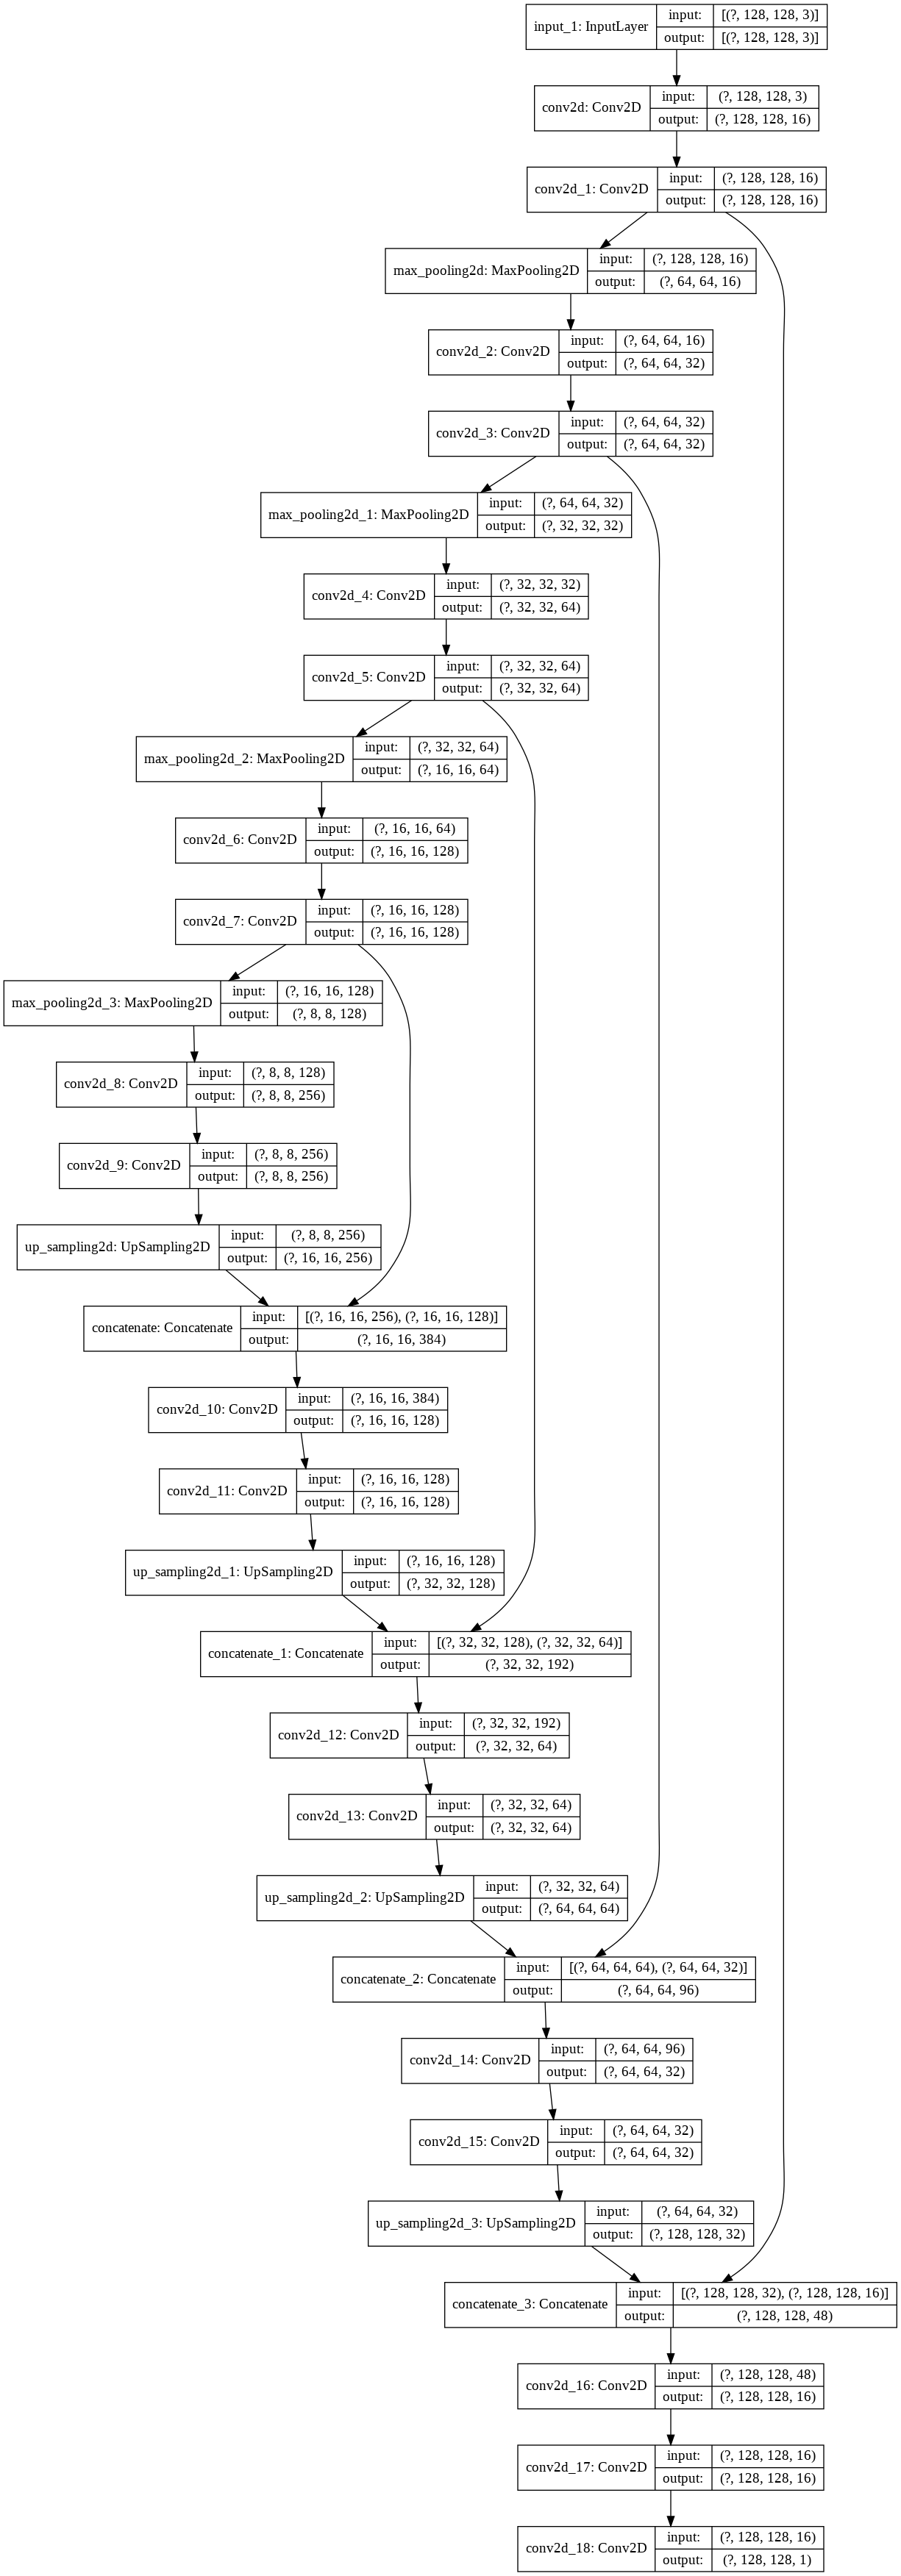

In [6]:
tf.keras.utils.plot_model(model, to_file='unet.png', show_shapes=True)